In [1]:
from dataset.dataset import Dataset

dataset_indoor = Dataset(uri='mongodb://10.247.166.29:27017', db_name='server_db',collection_name='plalion_klaen_sensor')
dataset_indoor.connect_mongodb_collection()
# delete sys.path
# sys.path.remove(os.path.abspath('dataset'))

In [2]:
df_indoor = dataset_indoor.create_indoor_data()
df_indoor.info()
df_indoor.set_index('timestamp', inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380657 entries, 0 to 380656
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   temperature  380657 non-null  float64       
 1   humidity     380657 non-null  float64       
 2   ozone        380657 non-null  float64       
 3   dust         380657 non-null  int64         
 4   co2          380657 non-null  int64         
 5   voc          380657 non-null  int64         
 6   timestamp    380657 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(3), int64(3)
memory usage: 20.3 MB


In [3]:
import pandas as pd 
start_date = "2024-04-01"
end_date = "2024-08-01"
daily_data = df_indoor[(df_indoor.index.date >= pd.to_datetime(start_date).date()) & (df_indoor.index.date < pd.to_datetime(end_date).date())]
daily_data = daily_data[['co2', 'voc', 'dust','temperature','humidity']]


In [4]:
resample_min = daily_data.resample('min').mean()
resample_min.interpolate(method='linear', inplace=True)

print(resample_min.shape)
print(resample_min.info())


(144856, 5)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144856 entries, 2024-04-01 00:00:00 to 2024-07-10 14:15:00
Freq: min
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   co2          144856 non-null  float64
 1   voc          144856 non-null  float64
 2   dust         144856 non-null  float64
 3   temperature  144856 non-null  float64
 4   humidity     144856 non-null  float64
dtypes: float64(5)
memory usage: 6.6 MB
None


In [5]:
import pandas as pd 
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [6]:
df = resample_min.copy()

scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df)
data_scaled_df = pd.DataFrame(data_scaled, columns=df.columns, index=df.index)

# split dataset into train and validation sets
# train_size = int(len(data_scaled) * 0.80)
# val_size = len(data_scaled) - train_size
# train, val = data_scaled[0:train_size,:], data_scaled[train_size:len(data_scaled),:]
from sklearn.model_selection import train_test_split
train, val = train_test_split(data_scaled_df, test_size=0.2, shuffle=False, random_state=42)

# # convert to tensor
train_tensor = torch.FloatTensor(train.values)
val_tensor = torch.FloatTensor(val.values)
full_tensor = torch.FloatTensor(data_scaled_df.values)
train_set = TensorDataset(train_tensor)
val_set = TensorDataset(val_tensor)
full_set = TensorDataset(torch.FloatTensor(full_tensor))
train_dataloader = DataLoader(train_set, batch_size=32, shuffle=False)
val_dataloader = DataLoader(val_set, batch_size=32, shuffle=False)
full_dataloader = DataLoader(full_set, batch_size=32, shuffle=False)


# tensor_data = torch.FloatTensor(data_scaled)
# dataset = TensorDataset(tensor_data)
# dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

In [7]:
print(train_tensor.shape)
print(train.shape)
print(data_scaled_df.shape)

torch.Size([115884, 5])
(115884, 5)
(144856, 5)


In [8]:
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim, hidden_dim=128):
        super(VAE, self).__init__()
        # Encoder
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)  # Batch normalization
        self.dropout1 = nn.Dropout(p=0.3)     # Dropout to reduce overfitting
        self.fc2_mu = nn.Linear(hidden_dim, latent_dim)   # Mean
        self.fc2_logvar = nn.Linear(hidden_dim, latent_dim) # Log variance
        
        # Decoder
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.bn3 = nn.BatchNorm1d(hidden_dim)  # Batch normalization
        self.dropout3 = nn.Dropout(p=0.3)     # Dropout
        self.fc4 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h1 = torch.relu(self.bn1(self.fc1(x))) # Adding BatchNorm and ReLU
        h1 = self.dropout1(h1)  # Dropout applied
        return self.fc2_mu(h1), self.fc2_logvar(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = torch.relu(self.bn3(self.fc3(z))) # Adding BatchNorm and ReLU
        h3 = self.dropout3(h3)  # Dropout applied
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [9]:
def loss_function(recon_x, x, mu, logvar):
    # Reconstruction loss (can use MSE or Binary Cross-Entropy based on data)
    MSE = nn.functional.mse_loss(recon_x, x, reduction='sum')
    # KL Divergence to regularize the latent space
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + KLD

C:\Users\pknub\AppData\Local\Temp\ipykernel_19480\2170238547.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_data_tensor = torch.tensor(train_tensor, dtype=torch.float)
C:\Users\pknub\AppData\Local\Temp\ipykernel_19480\2170238547.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_data_tensor = torch.tensor(val_tensor, dtype=torch.float)
C:\Users\pknub\AppData\Local\Temp\ipykernel_19480\2170238547.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  full_data_tensor = torch.tensor(full_tensor, dtype=torch.float)


Epoch 0, Train Loss: 336294.96875, Validation Loss: 30255.572265625
Epoch 10, Train Loss: 131258.15625, Validation Loss: 18148.75390625
Epoch 20, Train Loss: 88494.4921875, Validation Loss: 12759.923828125
Epoch 30, Train Loss: 64426.25, Validation Loss: 9683.2158203125
Epoch 40, Train Loss: 52023.078125, Validation Loss: 8729.4853515625
Epoch 50, Train Loss: 43430.4765625, Validation Loss: 8154.49658203125
Epoch 60, Train Loss: 37417.8828125, Validation Loss: 7627.22265625
Epoch 70, Train Loss: 32813.1171875, Validation Loss: 7291.97607421875
Epoch 80, Train Loss: 29182.240234375, Validation Loss: 7061.56298828125
Epoch 90, Train Loss: 26109.8984375, Validation Loss: 6820.56298828125
Epoch 100, Train Loss: 23525.41796875, Validation Loss: 6667.30615234375
Epoch 110, Train Loss: 21431.97265625, Validation Loss: 6500.20703125
Epoch 120, Train Loss: 19589.33203125, Validation Loss: 6387.0634765625
Epoch 130, Train Loss: 18136.970703125, Validation Loss: 6306.2353515625
Epoch 140, Train L

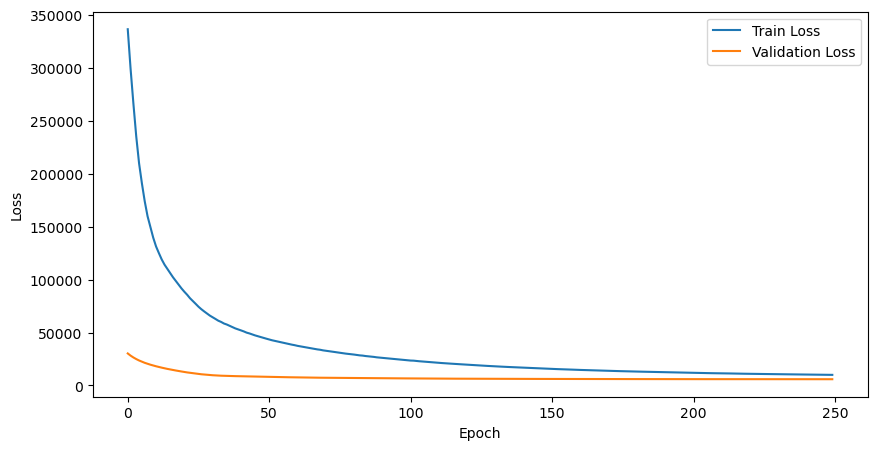

In [10]:
# Model parameters
input_dim = data_scaled_df.shape[1]
latent_dim = 10

# Initialize VAE model, optimizer
vae = VAE(input_dim=input_dim, latent_dim=latent_dim, hidden_dim=128)

# Optimizer with L2 regularization (weight decay)
optimizer = optim.Adam(vae.parameters(), lr=1e-3, weight_decay=1e-5)

# Convert data to PyTorch tensor
train_data_tensor = torch.tensor(train_tensor, dtype=torch.float)
val_data_tensor = torch.tensor(val_tensor, dtype=torch.float)
full_data_tensor = torch.tensor(full_tensor, dtype=torch.float)

# Training loop
epochs = 250
train_history = []
val_history = []

for epoch in range(epochs):
    # Training phase
    vae.train()
    recon_batch, mu, logvar = vae(train_data_tensor)
    loss = loss_function(recon_batch, train_data_tensor, mu, logvar)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_history.append(loss.item())

    # Validation phase
    vae.eval()
    with torch.no_grad():
        recon_batch, mu, logvar = vae(val_data_tensor)
        val_loss = loss_function(recon_batch, val_data_tensor, mu, logvar)
        val_history.append(val_loss.item())

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Train Loss: {train_history[-1]}, Validation Loss: {val_history[-1]}')

# plot training and validation loss 
plt.figure(figsize=(10, 5))
plt.plot(train_history, label='Train Loss')
plt.plot(val_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [11]:
print(train.shape)
print(train.info())
df_train = resample_min.iloc[:len(train)]
df_val = resample_min.iloc[len(train):len(train) + len(val)]
print(df_train.head(2))
print(df_val.head(2))
print(df_train.shape)
print(train_data_tensor.shape)


(115884, 5)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 115884 entries, 2024-04-01 00:00:00 to 2024-06-20 11:23:00
Freq: min
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   co2          115884 non-null  float64
 1   voc          115884 non-null  float64
 2   dust         115884 non-null  float64
 3   temperature  115884 non-null  float64
 4   humidity     115884 non-null  float64
dtypes: float64(5)
memory usage: 5.3 MB
None
                            co2         voc       dust  temperature  humidity
timestamp                                                                    
2024-04-01 00:00:00  246.333333  610.833333  33.500000         26.0      39.0
2024-04-01 00:01:00  233.833333  580.333333  28.333333         26.0      39.0
                      co2    voc  dust  temperature  humidity
timestamp                                                    
2024-06-20 11:24:00  28.0  420.0  13.0         37.0 

Normal data points: 110081
Anomalous data points: 5803


C:\Users\pknub\AppData\Local\Temp\ipykernel_19480\25999514.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['reconstruction_error'] = reconstruction_error.numpy()
C:\Users\pknub\AppData\Local\Temp\ipykernel_19480\25999514.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['anomaly_vae'] = anomalies


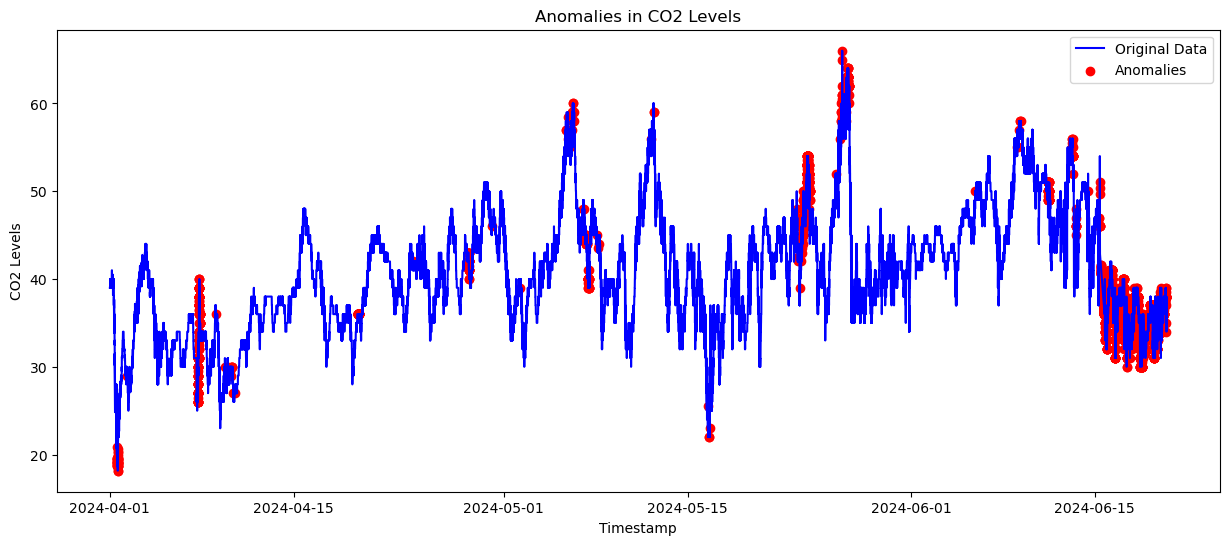

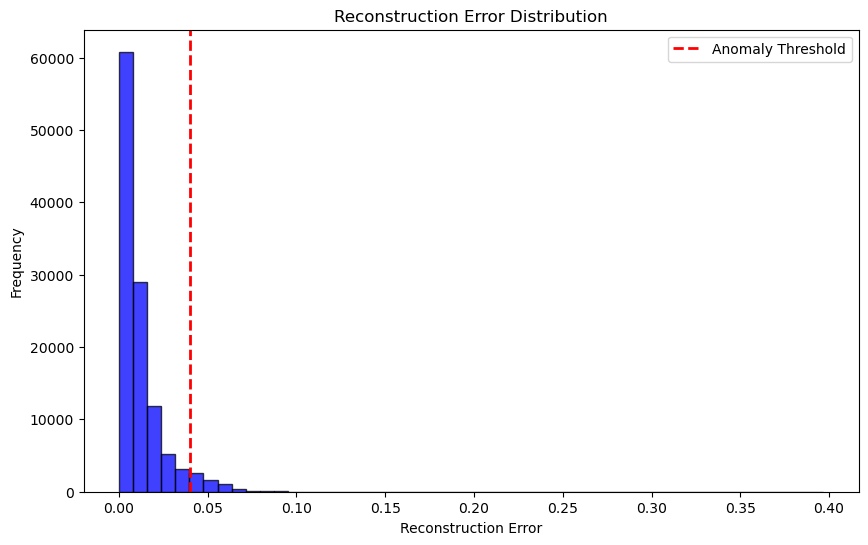

In [12]:
# Training Dataset
vae.eval()
with torch.no_grad():
    recon_data, _, _ = vae(train_data_tensor)
    reconstruction_error = torch.mean((train_data_tensor - recon_data) ** 2, dim=1)

df_train['reconstruction_error'] = reconstruction_error.numpy()

# Threshold for distinguishing anomalies
threshold = reconstruction_error.mean() + 2 * reconstruction_error.std()
anomalies = reconstruction_error > threshold

df_train['anomaly_vae'] = anomalies
# Normal data points
normal_data = df_train[df_train['anomaly_vae'] == False]
anomalous_data = df_train[df_train['anomaly_vae'] == True]

# Display normal and anomalous data
print("Normal data points:", normal_data.shape[0])
print("Anomalous data points:", anomalous_data.shape[0])

# Plotting the anomalies with the original dataset
plt.figure(figsize=(15, 6))

# Plot original data
plt.plot(df_train.index, df_train['humidity'], label='Original Data', color='blue')

# Plot anomalies
plt.scatter(df_train.index[df_train['anomaly_vae']], df_train['humidity'][df_train['anomaly_vae']], color='red', label='Anomalies')

plt.xlabel('Timestamp')
plt.ylabel('CO2 Levels')
plt.title('Anomalies in CO2 Levels')
plt.legend()
plt.show()

# Plotting the reconstruction error distribution
plt.figure(figsize=(10, 6))
plt.hist(df_train['reconstruction_error'], bins=50, alpha=0.75, color='blue', edgecolor='black')
plt.axvline(threshold, color='red', linestyle='dashed', linewidth=2, label='Anomaly Threshold')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Reconstruction Error Distribution')
plt.legend()
plt.show()


In [13]:
# display(df_train[(df_train['anomaly_vae'] == False) & (df_train['co2'] >= 1000)] )
# display(df_train[df_train['co2'] >= 1000])
# print(df_train[df_train['co2'] >= 1000])
print("Normal Values > 1000 : ",df_train[(df_train['anomaly_vae'] == False) & (df_train['co2'] >= 1000)].shape[0])
print("Anomalies Values > 1000 : ",df_train[(df_train['anomaly_vae'] == True) & (df_train['co2'] >= 1000)].shape[0])

print("Normal Values < 1000 : ",df_train[(df_train['anomaly_vae'] == False) & (df_train['co2'] <= 1000)].shape[0])
print("Anomalies Values < 1000 : ",df_train[(df_train['anomaly_vae'] == True) & (df_train['co2'] <= 1000)].shape[0])
print("Min",df_train[(df_train['anomaly_vae'] == False) & (df_train['co2'] <= 1000)].min())
print("Max",df_train[(df_train['anomaly_vae'] == False) & (df_train['co2'] <= 1000)].max())

Normal Values > 1000 :  374
Anomalies Values > 1000 :  471
Normal Values < 1000 :  109708
Anomalies Values < 1000 :  5332
Min co2                           0.0
voc                         400.0
dust                          0.0
temperature             24.666667
humidity                     19.5
reconstruction_error     0.000006
anomaly_vae                 False
dtype: object
Max co2                       1000.0
voc                       3856.0
dust                        74.0
temperature                 40.0
humidity                    62.0
reconstruction_error    0.040281
anomaly_vae                False
dtype: object


Normal data points: 28387
Anomalous data points: 585


C:\Users\pknub\AppData\Local\Temp\ipykernel_19480\344917339.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val['reconstruction_error'] = reconstruction_error.numpy()
C:\Users\pknub\AppData\Local\Temp\ipykernel_19480\344917339.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val['anomaly_vae'] = anomalies


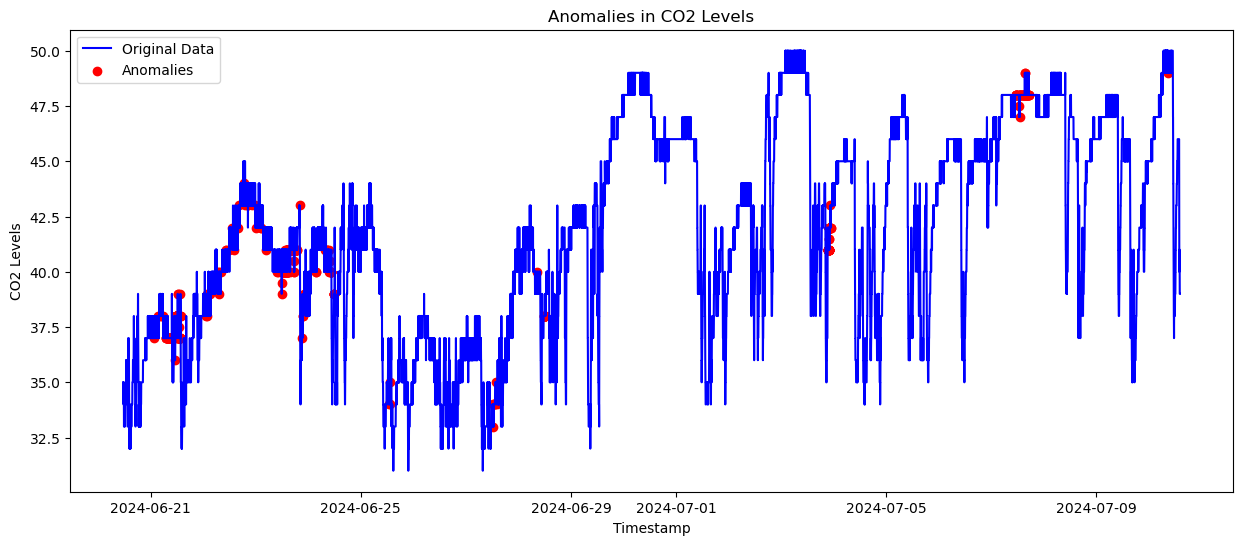

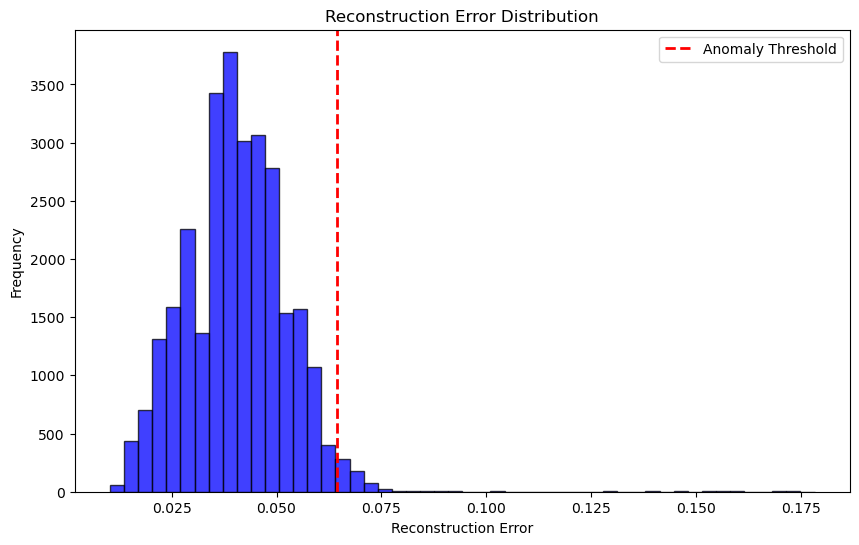

In [14]:
# Validation Dataset
vae.eval()
with torch.no_grad():
    recon_data, _, _ = vae(val_data_tensor)
    reconstruction_error = torch.mean((val_data_tensor - recon_data) ** 2, dim=1)

df_val['reconstruction_error'] = reconstruction_error.numpy()

# Threshold for distinguishing anomalies
threshold = reconstruction_error.mean() + 2 * reconstruction_error.std()
anomalies = reconstruction_error > threshold

df_val['anomaly_vae'] = anomalies
# Normal data points
normal_data = df_val[df_val['anomaly_vae'] == False]
anomalous_data = df_val[df_val['anomaly_vae'] == True]

# Display normal and anomalous data
print("Normal data points:", normal_data.shape[0])
print("Anomalous data points:", anomalous_data.shape[0])

# Plotting the anomalies with the original dataset
plt.figure(figsize=(15, 6))

# Plot original data
plt.plot(df_val.index, df_val['humidity'], label='Original Data', color='blue')

# Plot anomalies
plt.scatter(df_val.index[df_val['anomaly_vae']], df_val['humidity'][df_val['anomaly_vae']], color='red', label='Anomalies')

plt.xlabel('Timestamp')
plt.ylabel('CO2 Levels')
plt.title('Anomalies in CO2 Levels')
plt.legend()
plt.show()

# Plotting the reconstruction error distribution
plt.figure(figsize=(10, 6))
plt.hist(df_val['reconstruction_error'], bins=50, alpha=0.75, color='blue', edgecolor='black')
plt.axvline(threshold, color='red', linestyle='dashed', linewidth=2, label='Anomaly Threshold')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Reconstruction Error Distribution')
plt.legend()
plt.show()


Normal data points: 138588
Anomalous data points: 6268


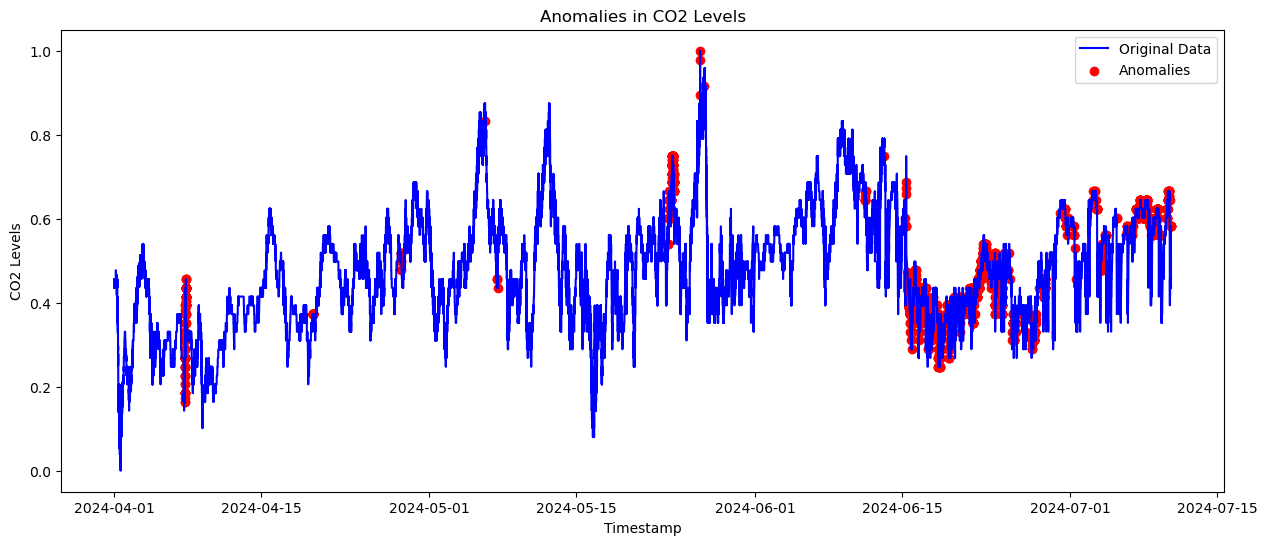

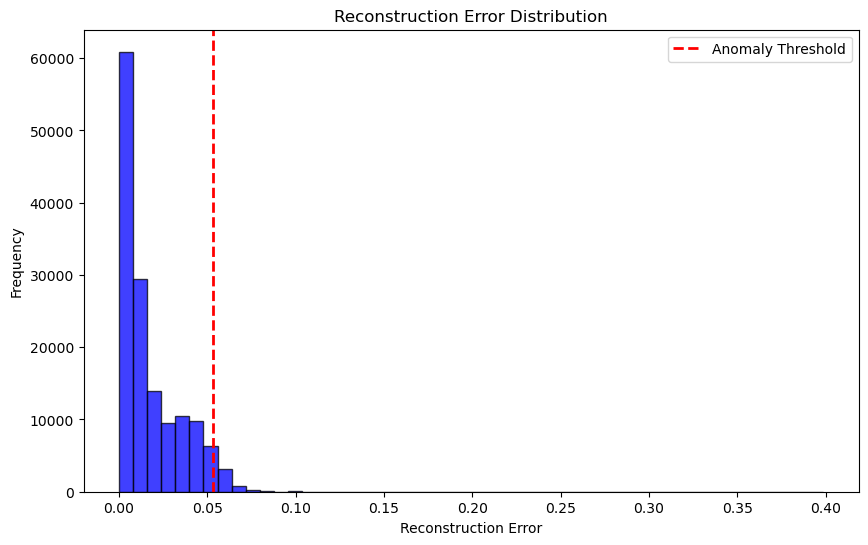

In [15]:
vae.eval()
with torch.no_grad():
    recon_data, _, _ = vae(full_data_tensor)
    reconstruction_error = torch.mean((full_data_tensor - recon_data) ** 2, dim=1)

data_scaled_df['reconstruction_error'] = reconstruction_error.numpy()
resample_min['reconstruction_error'] = reconstruction_error.numpy()

# Threshold for distinguishing anomalies
threshold = reconstruction_error.mean() + 2 * reconstruction_error.std()
anomalies = reconstruction_error > threshold

data_scaled_df['anomaly_vae'] = anomalies
resample_min['anomaly_vae'] = anomalies
# Normal data points
normal_data = data_scaled_df[data_scaled_df['anomaly_vae'] == False]
anomalous_data = data_scaled_df[data_scaled_df['anomaly_vae'] == True]

# Display normal and anomalous data
print("Normal data points:", normal_data.shape[0])
print("Anomalous data points:", anomalous_data.shape[0])

# Plotting the anomalies with the original dataset
plt.figure(figsize=(15, 6))

# Plot original data
plt.plot(data_scaled_df.index, data_scaled_df['humidity'], label='Original Data', color='blue')

# Plot anomalies
plt.scatter(data_scaled_df.index[data_scaled_df['anomaly_vae']], data_scaled_df['humidity'][data_scaled_df['anomaly_vae']], color='red', label='Anomalies')

plt.xlabel('Timestamp')
plt.ylabel('CO2 Levels')
plt.title('Anomalies in CO2 Levels')
plt.legend()
plt.show()

# Plotting the reconstruction error distribution
plt.figure(figsize=(10, 6))
plt.hist(data_scaled_df['reconstruction_error'], bins=50, alpha=0.75, color='blue', edgecolor='black')
plt.axvline(threshold, color='red', linestyle='dashed', linewidth=2, label='Anomaly Threshold')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Reconstruction Error Distribution')
plt.legend()
plt.show()


(138588, 7)
(6268, 7)


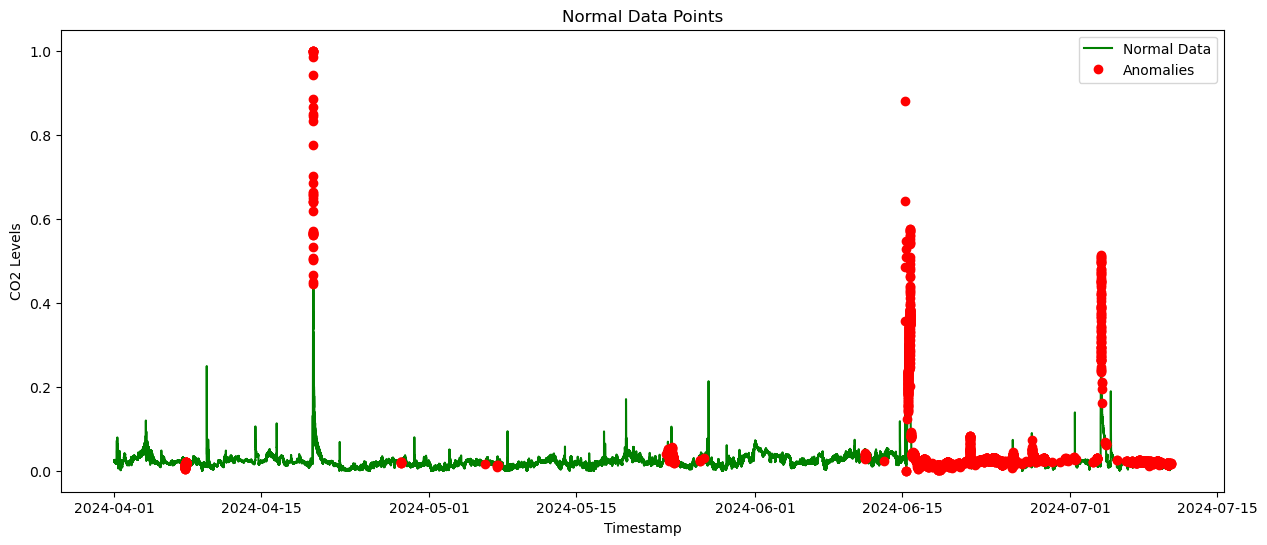

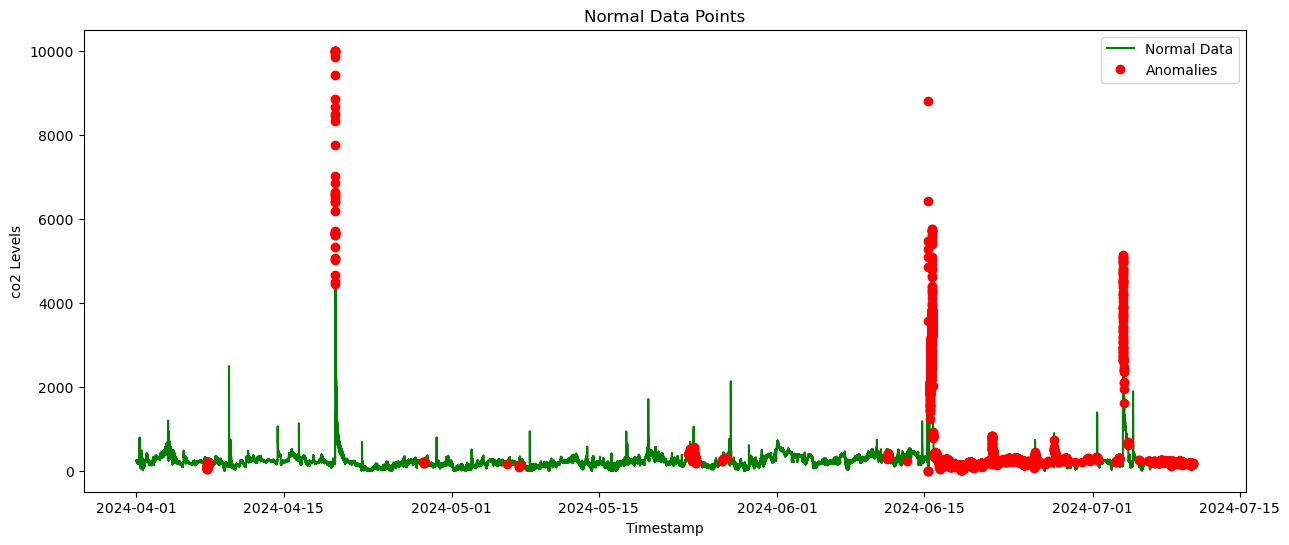

In [16]:
df_normal_scale = data_scaled_df[data_scaled_df['anomaly_vae'] == False]
df_normal = resample_min[resample_min['anomaly_vae'] == False]
df_anomalies_scale = data_scaled_df[data_scaled_df['anomaly_vae'] == True]
df_anomalies = resample_min[resample_min['anomaly_vae'] == True]
print(df_normal.shape)
print(df_anomalies.shape)

plt.figure(figsize=(15, 6))
# plt.plot(data_scaled_df.index, data_scaled_df['humidity'], label='Original Data', color='blue')
plt.plot(df_normal_scale.index, df_normal_scale['co2'], label='Normal Data', color='green')
plt.plot(df_anomalies_scale.index, df_anomalies_scale['co2'], 'ro', label='Anomalies')
plt.title('Normal Data Points')
plt.xlabel('Timestamp')
plt.ylabel('CO2 Levels')
plt.legend()
plt.show()

plt.figure(figsize=(15, 6))
# plt.plot(data_scaled_df.index, data_scaled_df['humidity'], label='Original Data', color='blue')
plt.plot(df_normal.index, df_normal['co2'], label='Normal Data', color='green')
plt.plot(df_anomalies.index, df_anomalies['co2'], 'ro', label='Anomalies')
plt.title('Normal Data Points')
plt.xlabel('Timestamp')
plt.ylabel('co2 Levels')
plt.legend()
plt.show()


In [17]:
df_normal_features = df_normal_scale[['co2', 'voc', 'dust','temperature','humidity']]
df_normal_features.head(3)

,co2,voc,dust,temperature,humidity
timestamp,,,,,
2024-04-01 00:00:00,0.024636,0.021964,0.270161,0.072727,0.43554
2024-04-01 00:01:00,0.023386,0.018787,0.228495,0.072727,0.43554
2024-04-01 00:02:00,0.023419,0.019516,0.243280,0.072727,0.43554


In [18]:
data = np.vstack([df_normal_features.values, df_anomalies_scale[['co2', 'voc', 'dust','temperature','humidity']].values])
labels = np.hstack([np.zeros(df_normal_features.shape[0]), np.ones(df_anomalies_scale.shape[0])])
# labels = np.hstack([np.zeros(df_normal_features.shape[0])])

df_normal_tensor = torch.FloatTensor(df_normal_features.values)
df_all_data_tensor = torch.FloatTensor(data)
df_labels_tensor = torch.LongTensor(labels)
df_normal_set = TensorDataset(df_normal_tensor)
df_normal_dataloader = DataLoader(df_normal_set, batch_size=32, shuffle=False)


print(data.shape)
print(df_labels_tensor.shape)

print(df_normal_tensor.shape)
print(df_all_data_tensor.shape)

(144856, 5)
torch.Size([144856])
torch.Size([138588, 5])
torch.Size([144856, 5])


In [19]:
class VAE_LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE_LSTM, self).__init__()
        self.lstm_encoder = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        self.lstm_decoder = nn.LSTM(latent_dim, hidden_dim, batch_first=True)
        self.fc_out = nn.Linear(hidden_dim, input_dim)
        self.dropout = nn.Dropout(0.2)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)

    def encode(self, x):
        _, (h_n, _) = self.lstm_encoder(x)
        h_n = h_n[-1]
        mu = self.fc_mu(h_n)
        logvar = self.fc_logvar(h_n)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, seq_len):
        z = z.unsqueeze(1).repeat(1, seq_len, 1)  # Expand latent vector to match the sequence length
        lstm_out, _ = self.lstm_decoder(z)
        lstm_out = self.dropout(lstm_out)
        lstm_out = lstm_out.contiguous().view(-1, lstm_out.size(-1))  # Flatten the LSTM output for batch normalization
        lstm_out = self.bn2(lstm_out)
        lstm_out = lstm_out.view(-1, seq_len, lstm_out.size(-1))  # Reshape back to sequence format
        recon_x = self.fc_out(lstm_out)
        return recon_x

    def forward(self, x):
        seq_len = x.size(1)
        mu, logvar = self.encode(x)  # Encode the input to obtain mu and logvar
        z = self.reparameterize(mu, logvar)  # Reparameterization trick to sample z
        recon_x = self.decode(z, seq_len)  # Decode z to reconstruct the input
        return recon_x, mu, logvar

In [20]:
# Loss function (Reconstruction Loss + KL Divergence)
def loss_function(recon_x, x, mu, logvar):
    # Reconstruction loss (using MSE as it is continuous data)
    MSE = nn.functional.mse_loss(recon_x, x, reduction='sum')
    # KL Divergence to regularize the latent space
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + KLD

# Helper function to generate lagged sequences
def create_lagged_sequences(data, n_lags=5):
    """
    Create sequences with n_lags from time-series data.
    Args:
        data: The scaled time-series data (DataFrame or numpy array).
        n_lags: The number of previous time steps to include in each sequence.
    Returns:
        sequences: A numpy array of shape (num_sequences, n_lags + 1, num_features).
    """
    sequences = []
    total_data = len(data)  # Ensure total_data is an integer
    for i in range(n_lags, total_data):
        # Get a sequence of current time step and previous `n_lags` time steps
        seq = data[i - n_lags:i + 1]  # Add the current time step to the sequence
        sequences.append(seq)
    
    return np.array(sequences)


In [21]:
# n_lags = 5
# data_tensor = torch.tensor(create_lagged_sequences(df_normal_tensor.numpy().astype(np.float32), n_lags), dtype=torch.float)
# all_sequences = create_lagged_sequences(df_all_data_tensor.numpy(), n_lags)
# label_sequences = create_lagged_sequences(labels, n_lags)

# # labels = np.hstack([np.zeros(df_all_data_tensor.shape[0])])


# print(data_tensor.shape)
# print(df_all_data_tensor.shape)
# print(label_sequences.shape)

Epoch 0, Train Loss: 1320482.5, Validation Loss: 324248.03125
Epoch 10, Train Loss: 586221.6875, Validation Loss: 274134.15625
Epoch 20, Train Loss: 495232.625, Validation Loss: 239150.984375
Epoch 30, Train Loss: 402187.40625, Validation Loss: 209182.4375
Epoch 40, Train Loss: 342600.9375, Validation Loss: 180660.65625
Epoch 50, Train Loss: 293731.4375, Validation Loss: 152403.453125
Epoch 60, Train Loss: 253202.59375, Validation Loss: 126260.0
Epoch 70, Train Loss: 220159.234375, Validation Loss: 105242.96875
Epoch 80, Train Loss: 193288.984375, Validation Loss: 89756.78125
Epoch 90, Train Loss: 172381.796875, Validation Loss: 78965.0078125
Epoch 100, Train Loss: 156396.546875, Validation Loss: 71918.0703125
Epoch 110, Train Loss: 143331.390625, Validation Loss: 67843.984375
Epoch 120, Train Loss: 132992.9375, Validation Loss: 65603.4296875
Epoch 130, Train Loss: 123976.7265625, Validation Loss: 64605.37890625
Epoch 140, Train Loss: 116721.3125, Validation Loss: 63910.13671875
Epoch 

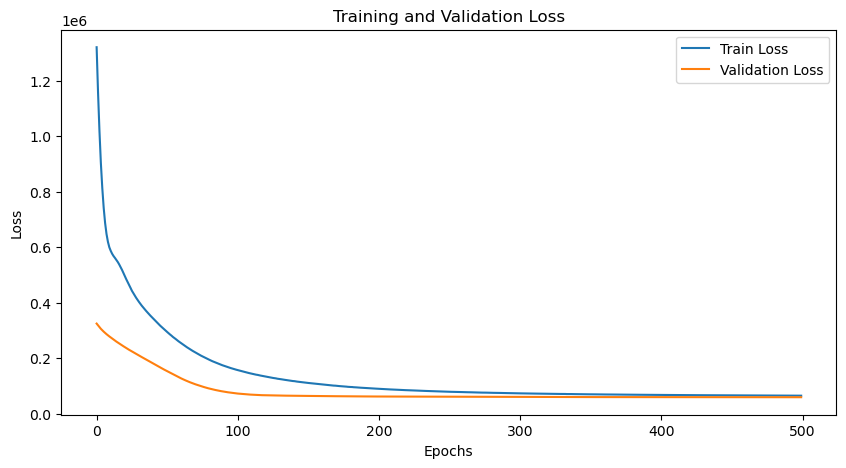

In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Prepare the lagged sequences (with 3 to 5 lags)
n_lags = 5  # Number of lags (sequence length)
data_tensor = torch.tensor(create_lagged_sequences(df_normal_features.astype(np.float32), n_lags), dtype=torch.float).to(device)
all_sequences_tensor = torch.tensor(create_lagged_sequences(df_all_data_tensor.numpy(), n_lags), dtype=torch.float).to(device)
label_sequences = torch.tensor(create_lagged_sequences(df_labels_tensor.numpy(), n_lags), dtype=torch.long).to(device)

# Initialize the VAE-LSTM model
input_dim = data_tensor.shape[-1]  # 5 features (co2, voc, dust, temperature, humidity)
latent_dim = 10
hidden_dim = 64

vae_lstm = VAE_LSTM(input_dim=input_dim, hidden_dim=hidden_dim, latent_dim=latent_dim).to(device)


# Optimizer
optimizer = optim.Adam(vae_lstm.parameters(), lr=1e-3)

# Example training loop (with sequences and temporal dependencies)
epochs = 500
train_history = []
val_history = []

for epoch in range(epochs):
    vae_lstm.train()
    recon_batch, mu, logvar = vae_lstm(data_tensor)
    loss = loss_function(recon_batch, data_tensor, mu, logvar)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_history.append(loss.item())

    # Validation phase
    vae_lstm.eval()
    with torch.no_grad():
        recon_batch, mu, logvar = vae_lstm(data_tensor)
        val_loss = loss_function(recon_batch, data_tensor, mu, logvar)
        val_history.append(val_loss.item())

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Train Loss: {train_history[-1]}, Validation Loss: {val_history[-1]}')

plt.figure(figsize=(10, 5))
plt.plot(train_history, label='Train Loss')
plt.plot(val_history, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [37]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

# Calculate reconstruction error
vae_lstm.eval()
with torch.no_grad():
    reconstructed, _, _ = vae_lstm(all_sequences_tensor)
reconstruction_error = torch.mean((all_sequences_tensor - reconstructed) ** 2, dim=(1, 2)).cpu().numpy()

# Set threshold for anomaly detection
# threshold = np.percentile(reconstruction_error, 95)  # Example threshold
threshold = reconstruction_error.mean() + 2 * reconstruction_error.std()

# Predict anomalies based on reconstruction error
predictions = (reconstruction_error > threshold).astype(int)

print("labels : ", labels.shape)
print("predictions : ", predictions.shape)
print(all_sequences_tensor.shape)
print(label_sequences.shape)
print(" -- ",predictions)

labels :  (144856,)
predictions :  (144851,)
torch.Size([144851, 6, 5])
torch.Size([144851, 6])
 --  [0 0 0 ... 0 0 0]


In [38]:
# Ensure predictions and label_sequences have compatible shapes
print("predictions:", predictions.shape)
print("label_sequences:", label_sequences.shape)

# Check if predictions and label_sequences are already NumPy arrays
if isinstance(predictions, torch.Tensor):
    predictions_cpu = predictions.cpu().numpy()
else:
    predictions_cpu = predictions

if isinstance(label_sequences, torch.Tensor):
    label_sequences_cpu = label_sequences.cpu().numpy()
else:
    label_sequences_cpu = label_sequences

# Flatten label_sequences to match the shape of predictions
flattened_labels = label_sequences_cpu[:, 0]  # Assuming the first column represents the labels
print("flattened_labels:", flattened_labels.shape)

# Calculate confusion matrix and metrics
cm = confusion_matrix(flattened_labels, predictions_cpu)
precision = precision_score(flattened_labels, predictions_cpu)
recall = recall_score(flattened_labels, predictions_cpu)
f1 = f1_score(flattened_labels, predictions_cpu)
accuracy = accuracy_score(flattened_labels, predictions_cpu)

print("Confusion Matrix:")
print(cm)
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
print(f"Accuracy: {accuracy}")

predictions: (144851,)
label_sequences: torch.Size([144851, 6])
flattened_labels: (144851,)
Confusion Matrix:
[[138211    377]
 [  1673   4590]]
Precision: 0.9240990537547815
Recall: 0.7328756187130768
F1-Score: 0.8174532502226179
Accuracy: 0.9858475260785221


In [39]:
import torch
import torch.nn as nn

class VAE_GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE_GRU, self).__init__()
        
        # GRU-based Encoder
        self.gru_encoder = nn.GRU(input_dim, hidden_dim, batch_first=True)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        
        # GRU-based Decoder
        self.gru_decoder = nn.GRU(latent_dim, hidden_dim, batch_first=True)
        self.fc_out = nn.Linear(hidden_dim, input_dim)

        # Dropout and Batch Normalization for regularization
        self.dropout = nn.Dropout(0.2)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)

    def encode(self, x):
        _, h_n = self.gru_encoder(x)  # h_n is the hidden state from GRU encoder
        h_n = h_n[-1]  # Use the last hidden state from the GRU
        mu = self.fc_mu(h_n)
        logvar = self.fc_logvar(h_n)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, seq_len):
        z = z.unsqueeze(1).repeat(1, seq_len, 1)  # Expand latent vector to match the sequence length
        gru_out, _ = self.gru_decoder(z)
        
        # Apply dropout and batch normalization
        gru_out = self.dropout(gru_out)
        gru_out = gru_out.contiguous().view(-1, gru_out.size(-1))  # Flatten for batch normalization
        gru_out = self.bn2(gru_out)
        gru_out = gru_out.view(-1, seq_len, gru_out.size(-1))  # Reshape back to sequence format

        recon_x = self.fc_out(gru_out)  # Reconstruct the input features
        return recon_x

    def forward(self, x):
        seq_len = x.size(1)  # Get the sequence length from input
        mu, logvar = self.encode(x)  # Encode the input to obtain mu and logvar
        z = self.reparameterize(mu, logvar)  # Reparameterization trick to sample z
        recon_x = self.decode(z, seq_len)  # Decode z to reconstruct the input
        return recon_x, mu, logvar


Epoch 0, Train Loss: 1873297.625, Validation Loss: 569666.5
Epoch 10, Train Loss: 823937.3125, Validation Loss: 474366.5625
Epoch 20, Train Loss: 701047.1875, Validation Loss: 458853.375
Epoch 30, Train Loss: 599481.25, Validation Loss: 408199.84375
Epoch 40, Train Loss: 517147.59375, Validation Loss: 344398.75
Epoch 50, Train Loss: 452001.1875, Validation Loss: 279991.15625
Epoch 60, Train Loss: 392493.8125, Validation Loss: 226352.234375
Epoch 70, Train Loss: 338797.8125, Validation Loss: 184584.953125
Epoch 80, Train Loss: 291634.625, Validation Loss: 150092.125
Epoch 90, Train Loss: 252547.15625, Validation Loss: 120369.1796875
Epoch 100, Train Loss: 222409.40625, Validation Loss: 96894.1015625
Epoch 110, Train Loss: 199947.140625, Validation Loss: 81089.5625
Epoch 120, Train Loss: 183492.9375, Validation Loss: 72037.65625
Epoch 130, Train Loss: 170140.6875, Validation Loss: 67613.8203125
Epoch 140, Train Loss: 159383.5, Validation Loss: 65534.9453125
Epoch 150, Train Loss: 149567.

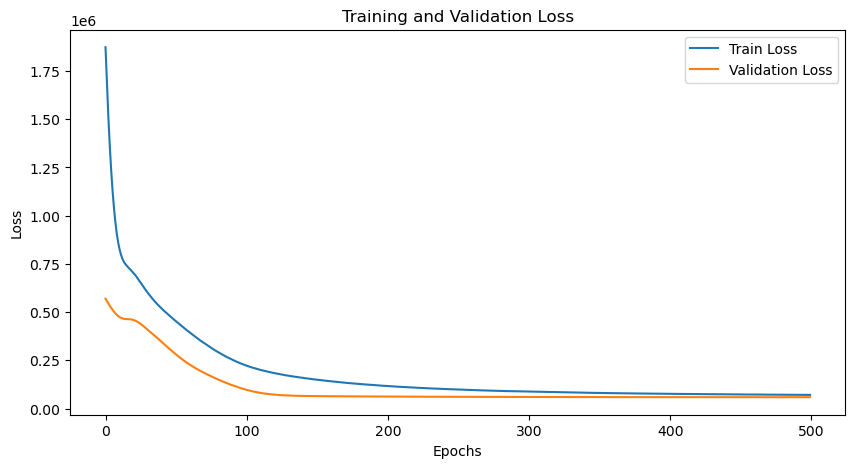

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Prepare the lagged sequences (with 3 to 5 lags)
n_lags = 5  # Number of lags (sequence length)
data_tensor = torch.tensor(create_lagged_sequences(df_normal_features.astype(np.float32), n_lags), dtype=torch.float).to(device)
all_sequences_tensor = torch.tensor(create_lagged_sequences(df_all_data_tensor.numpy(), n_lags), dtype=torch.float).to(device)
label_sequences = torch.tensor(create_lagged_sequences(df_labels_tensor.numpy(), n_lags), dtype=torch.long).to(device)

# Initialize the VAE-GRU model
input_dim = data_tensor.shape[-1]  # 5 features (co2, voc, dust, temperature, humidity)
latent_dim = 10
hidden_dim = 64

vae_gru = VAE_GRU(input_dim=input_dim, hidden_dim=hidden_dim, latent_dim=latent_dim).to(device)


# Optimizer
optimizer = optim.Adam(vae_gru.parameters(), lr=1e-3)

# Example training loop (with sequences and temporal dependencies)
epochs = 500
train_history = []
val_history = []

for epoch in range(epochs):
    vae_gru.train()
    recon_batch, mu, logvar = vae_gru(data_tensor)
    loss = loss_function(recon_batch, data_tensor, mu, logvar)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_history.append(loss.item())

    # Validation phase
    vae_gru.eval()
    with torch.no_grad():
        recon_batch, mu, logvar = vae_gru(data_tensor)
        val_loss = loss_function(recon_batch, data_tensor, mu, logvar)
        val_history.append(val_loss.item())

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Train Loss: {train_history[-1]}, Validation Loss: {val_history[-1]}')

plt.figure(figsize=(10, 5))
plt.plot(train_history, label='Train Loss')
plt.plot(val_history, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [41]:
# Calculate reconstruction error
vae_gru.eval()
with torch.no_grad():
    reconstructed, _, _ = vae_gru(all_sequences_tensor)
reconstruction_error = torch.mean((all_sequences_tensor - reconstructed) ** 2, dim=(1, 2)).cpu().numpy()

# Set threshold for anomaly detection
# threshold = np.percentile(reconstruction_error, 95)  # Example threshold
threshold = reconstruction_error.mean() + 2 * reconstruction_error.std()

# Predict anomalies based on reconstruction error
predictions = (reconstruction_error > threshold).astype(int)

print("labels : ", labels.shape)
print("predictions : ", predictions.shape)
print(all_sequences_tensor.shape)
print(label_sequences.shape)
print(" -- ",predictions)

labels :  (144856,)
predictions :  (144851,)
torch.Size([144851, 6, 5])
torch.Size([144851, 6])
 --  [0 0 0 ... 0 0 0]


In [42]:
# Ensure predictions and label_sequences have compatible shapes
print("predictions:", predictions.shape)
print("label_sequences:", label_sequences.shape)

# Check if predictions and label_sequences are already NumPy arrays
if isinstance(predictions, torch.Tensor):
    predictions_cpu = predictions.cpu().numpy()
else:
    predictions_cpu = predictions

if isinstance(label_sequences, torch.Tensor):
    label_sequences_cpu = label_sequences.cpu().numpy()
else:
    label_sequences_cpu = label_sequences

# Flatten label_sequences to match the shape of predictions
flattened_labels = label_sequences_cpu[:, 0]  # Assuming the first column represents the labels
print("flattened_labels:", flattened_labels.shape)

# Calculate confusion matrix and metrics
cm = confusion_matrix(flattened_labels, predictions_cpu)
precision = precision_score(flattened_labels, predictions_cpu)
recall = recall_score(flattened_labels, predictions_cpu)
f1 = f1_score(flattened_labels, predictions_cpu)
accuracy = accuracy_score(flattened_labels, predictions_cpu)

print("Confusion Matrix:")
print(cm)
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
print(f"Accuracy: {accuracy}")

predictions: (144851,)
label_sequences: torch.Size([144851, 6])
flattened_labels: (144851,)
Confusion Matrix:
[[138193    395]
 [  1374   4889]]
Precision: 0.9252460257380772
Recall: 0.7806163180584385
F1-Score: 0.8468000346410323
Accuracy: 0.9877874505526368


In [29]:
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from hmmlearn import hmm

# VAE-GRU model (same as defined before)
class VAE_GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE_GRU, self).__init__()
        # GRU-based Encoder
        self.gru_encoder = nn.GRU(input_dim, hidden_dim, batch_first=True)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        
        # GRU-based Decoder
        self.gru_decoder = nn.GRU(latent_dim, hidden_dim, batch_first=True)
        self.fc_out = nn.Linear(hidden_dim, input_dim)
        self.dropout = nn.Dropout(0.2)
        self.bn2 = nn.BatchNorm1d(hidden_dim)

    def encode(self, x):
        _, h_n = self.gru_encoder(x)
        h_n = h_n[-1]  # Use the last hidden state from the GRU
        mu = self.fc_mu(h_n)
        logvar = self.fc_logvar(h_n)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, seq_len):
        z = z.unsqueeze(1).repeat(1, seq_len, 1)  # Expand latent vector to match the sequence length
        gru_out, _ = self.gru_decoder(z)
        gru_out = self.dropout(gru_out)
        gru_out = gru_out.contiguous().view(-1, gru_out.size(-1))  # Flatten for batch normalization
        gru_out = self.bn2(gru_out)
        gru_out = gru_out.view(-1, seq_len, gru_out.size(-1))  # Reshape back to sequence format
        recon_x = self.fc_out(gru_out)  # Reconstruct the input features
        return recon_x

    def forward(self, x):
        seq_len = x.size(1)
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z, seq_len)
        return recon_x, mu, logvar

# Function to train VAE-GRU and HMM, and then compute the confusion matrix
def evaluate_with_hmm(vae_model, data_tensor, labels, n_components=5):
    """
    Evaluate the VAE-GRU model combined with HMM and compute confusion matrix.
    Args:
        vae_model: Trained VAE-GRU model.
        data_tensor: Input data tensor (sequences).
        labels: Ground truth labels for the sequences.
        n_components: Number of latent states in the HMM.
    Returns:
        Confusion matrix and other performance metrics.
    """
    vae_model.eval()

    # Step 1: Encode the sequences using VAE-GRU to get the latent representations
    latent_vectors = []
    with torch.no_grad():
        for seq in data_tensor:
            mu, logvar = vae_model.encode(seq.unsqueeze(0))
            z = vae_model.reparameterize(mu, logvar)  # Latent vector
            latent_vectors.append(z.squeeze(0).cpu().numpy())

    # Step 2: Train the HMM on the latent vectors
    latent_vectors = np.vstack(latent_vectors)
    hmm_model = hmm.GaussianHMM(n_components=n_components, covariance_type="full", n_iter=100)
    hmm_model.fit(latent_vectors)

    # Step 3: Use the HMM to predict hidden states
    predicted_hidden_states = hmm_model.predict(latent_vectors)

    # For demonstration, let's assume we want to classify certain hidden states as anomalies
    # For example, we might classify higher-numbered hidden states (e.g., state > n_components/2) as anomalies
    threshold_state = n_components // 2
    predictions = (predicted_hidden_states > threshold_state).astype(int)

    # Check if predictions and labels are already NumPy arrays
    if isinstance(predictions, torch.Tensor):
        predictions_cpu = predictions.cpu().numpy()
    else:
        predictions_cpu = predictions

    if isinstance(labels, torch.Tensor):
        labels_cpu = labels.cpu().numpy()
    else:
        labels_cpu = labels

    # Flatten labels to match the shape of predictions
    flattened_labels = labels_cpu[:, 0]  # Assuming the first column represents the labels
    print("flattened_labels:", flattened_labels.shape)
    # flattened_labels = labels_cpu.flatten()  # Assuming labels need to be flattened
    # print("flattened_labels:", flattened_labels.shape)
    print("predictions:", predictions_cpu.shape)

    # Step 4: Compute confusion matrix and other metrics
    cm = confusion_matrix(flattened_labels, predictions_cpu)
    precision = precision_score(flattened_labels, predictions_cpu)
    recall = recall_score(flattened_labels, predictions_cpu)
    f1 = f1_score(flattened_labels, predictions_cpu)
    accuracy = accuracy_score(flattened_labels, predictions_cpu)

    return cm, precision, recall, f1, accuracy


In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Prepare the lagged sequences (with 3 to 5 lags)
n_lags = 5  # Number of lags (sequence length)
data_tensor = torch.tensor(create_lagged_sequences(df_normal_features.astype(np.float32), n_lags), dtype=torch.float).to(device)
all_sequences_tensor = torch.tensor(create_lagged_sequences(df_all_data_tensor.numpy(), n_lags), dtype=torch.float).to(device)
label_sequences = torch.tensor(create_lagged_sequences(df_labels_tensor.numpy(), n_lags), dtype=torch.long).to(device)

# Initialize the VAE-GRU model
input_dim = data_tensor.shape[-1]  # 5 features (co2, voc, dust, temperature, humidity)
latent_dim = 10
hidden_dim = 64

# Initialize and train VAE-GRU (for demonstration, we'll assume it's already trained)
vae_gru_model = VAE_GRU(input_dim=input_dim, hidden_dim=hidden_dim, latent_dim=latent_dim).to(device)

Epoch 0, Train Loss: 1950259.25, Validation Loss: 369424.71875
Epoch 10, Train Loss: 695364.8125, Validation Loss: 305919.75
Epoch 20, Train Loss: 535249.9375, Validation Loss: 266347.75
Epoch 30, Train Loss: 457094.6875, Validation Loss: 223576.640625
Epoch 40, Train Loss: 378933.21875, Validation Loss: 174967.78125
Epoch 50, Train Loss: 330607.625, Validation Loss: 147374.125
Epoch 60, Train Loss: 289533.25, Validation Loss: 125928.171875
Epoch 70, Train Loss: 255909.84375, Validation Loss: 107725.8359375
Epoch 80, Train Loss: 228715.65625, Validation Loss: 92851.203125
Epoch 90, Train Loss: 206821.28125, Validation Loss: 81473.3125


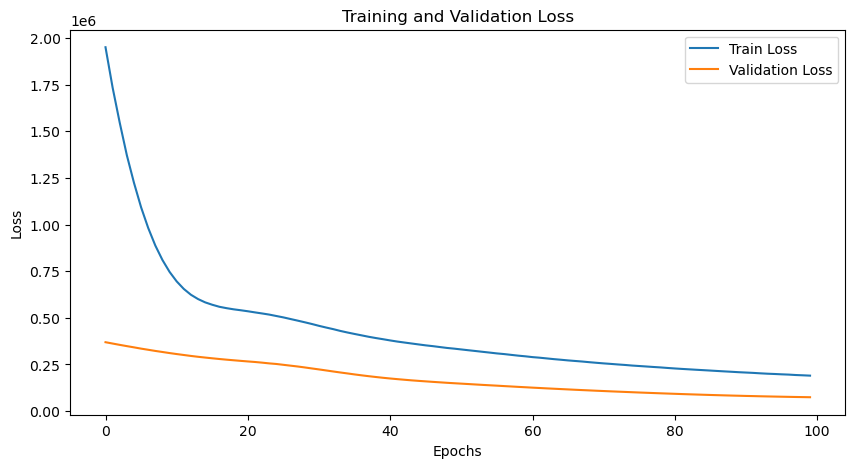

In [31]:
# Optimizer
optimizer = optim.Adam(vae_gru_model.parameters(), lr=1e-3)

# Example training loop (with sequences and temporal dependencies)
epochs = 100
train_history = []
val_history = []

for epoch in range(epochs):
    vae_gru_model.train()
    recon_batch, mu, logvar = vae_gru_model(data_tensor)
    loss = loss_function(recon_batch, data_tensor, mu, logvar)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_history.append(loss.item())

    # Validation phase
    vae_gru_model.eval()
    with torch.no_grad():
        recon_batch, mu, logvar = vae_gru_model(data_tensor)
        val_loss = loss_function(recon_batch, data_tensor, mu, logvar)
        val_history.append(val_loss.item())

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Train Loss: {train_history[-1]}, Validation Loss: {val_history[-1]}')

plt.figure(figsize=(10, 5))
plt.plot(train_history, label='Train Loss')
plt.plot(val_history, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [45]:
def evaluate_with_hmm(vae_model, data_tensor, labels, n_components=5, n_iter=100, n_restarts=10):
    """
    Evaluate the VAE-GRU model combined with HMM and compute confusion matrix.
    Args:
        vae_model: Trained VAE-GRU model.
        data_tensor: Input data tensor (sequences).
        labels: Ground truth labels for the sequences.
        n_components: Number of latent states in the HMM.
        n_iter: Number of iterations for HMM training.
        n_restarts: Number of restarts for HMM training to avoid local minima.
    Returns:
        Confusion matrix and other performance metrics.
    """
    vae_model.eval()

    # Step 1: Encode the sequences using VAE-GRU to get the latent representations
    latent_vectors = []
    reconstruction_errors = []
    with torch.no_grad():
        for seq in data_tensor:
            seq_len = seq.size(0)  # Get the sequence length
            mu, logvar = vae_model.encode(seq.unsqueeze(0))
            z = vae_model.reparameterize(mu, logvar)  # Latent vector
            recon_seq = vae_model.decode(z, seq_len)  # Pass seq_len to decode
            reconstruction_error = torch.mean((recon_seq - seq.unsqueeze(0))**2).item()
            latent_vectors.append(z.squeeze(0).cpu().numpy())
            reconstruction_errors.append(reconstruction_error)

    # Step 2: Train the HMM on the latent vectors
    latent_vectors = np.vstack(latent_vectors)
    best_hmm_model = None
    best_score = float('-inf')
    for _ in range(n_restarts):
        hmm_model = hmm.GaussianHMM(n_components=n_components, covariance_type="full", n_iter=n_iter)
        hmm_model.fit(latent_vectors)
        score = hmm_model.score(latent_vectors)
        if score > best_score:
            best_score = score
            best_hmm_model = hmm_model

    # Step 3: Use the HMM to predict hidden states
    predicted_hidden_states = best_hmm_model.predict(latent_vectors)

    # Step 4: Combine hidden states and reconstruction errors for anomaly detection
    threshold_state = n_components // 2
    predictions = (predicted_hidden_states > threshold_state).astype(int)

    # Check if predictions and labels are already NumPy arrays
    if isinstance(predictions, torch.Tensor):
        predictions_cpu = predictions.cpu().numpy()
    else:
        predictions_cpu = predictions

    if isinstance(labels, torch.Tensor):
        labels_cpu = labels.cpu().numpy()
    else:
        labels_cpu = labels

    # Flatten labels to match the shape of predictions
    flattened_labels = labels_cpu[:, 0]  # Assuming the first column represents the labels

    # Step 5: Compute confusion matrix and other metrics
    cm = confusion_matrix(flattened_labels, predictions_cpu)
    precision = precision_score(flattened_labels, predictions_cpu)
    recall = recall_score(flattened_labels, predictions_cpu)
    f1 = f1_score(flattened_labels, predictions_cpu)
    accuracy = accuracy_score(flattened_labels, predictions_cpu)

    return cm, precision, recall, f1, accuracy

In [46]:
# Evaluate using HMM and calculate confusion matrix
cm, precision, recall, f1, accuracy = evaluate_with_hmm(vae_gru, all_sequences_tensor, label_sequences, n_components=5)

# Print the results
print("Confusion Matrix:")
print(cm)
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
print(f"Accuracy: {accuracy}")

Confusion Matrix:
[[132761   5827]
 [  6004    259]]
Precision: 0.04255668747946106
Recall: 0.041353983713875136
F1-Score: 0.04194671633330634
Accuracy: 0.9183229663585339


In [43]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

# Use the latent space (mu) from the VAE-LSTM as input for GMM
vae_lstm.eval()
with torch.no_grad():
    _, mu, logvar = vae_lstm(all_sequences_tensor)  # Extract the latent space (mu) from the VAE-LSTM

latent_vectors = mu.cpu().numpy()

# Apply GMM to the latent vectors
n_components = 2  # Two clusters: normal and anomaly
gmm_model = GaussianMixture(n_components=n_components, covariance_type='full')

# Fit the GMM to the latent vectors
gmm_model.fit(latent_vectors)

# Predict cluster labels (0 = normal, 1 = anomaly)
gmm_labels = gmm_model.predict(latent_vectors)

# Calculate probabilities for each sample belonging to each cluster
gmm_probs = gmm_model.predict_proba(latent_vectors)

# Set the anomaly threshold based on probabilities
anomaly_prob_threshold = 0.5  # You can tune this threshold
predictions_gmm = (gmm_probs[:, 1] > anomaly_prob_threshold).astype(int)

# Ensure predictions and label_sequences have compatible shapes
print("predictions_gmm:", predictions_gmm.shape)
print("label_sequences:", label_sequences.shape)

if isinstance(predictions_gmm, torch.Tensor):
    predictions_cpu = predictions_gmm.cpu().numpy()
else:
    predictions_cpu = predictions_gmm

if isinstance(label_sequences, torch.Tensor):
    label_sequences_cpu = label_sequences.cpu().numpy()
else:
    label_sequences_cpu = label_sequences

# Flatten label_sequences to match the shape of predictions
flattened_labels = label_sequences_cpu[:, 0]  # Assuming the first column represents the labels
print("flattened_labels:", flattened_labels.shape)



# Calculate confusion matrix and metrics for GMM-enhanced model
cm_gmm = confusion_matrix(flattened_labels, predictions_gmm)
precision_gmm = precision_score(flattened_labels, predictions_gmm)
recall_gmm = recall_score(flattened_labels, predictions_gmm)
f1_gmm = f1_score(flattened_labels, predictions_gmm)
accuracy_gmm = accuracy_score(flattened_labels, predictions_gmm)

print("GMM-enhanced Confusion Matrix:")
print(cm_gmm)
print(f"Precision: {precision_gmm}")
print(f"Recall: {recall_gmm}")
print(f"F1-Score: {f1_gmm}")
print(f"Accuracy: {accuracy_gmm}")


predictions_gmm: (144851,)
label_sequences: torch.Size([144851, 6])
flattened_labels: (144851,)
GMM-enhanced Confusion Matrix:
[[109130  29458]
 [   350   5913]]
Precision: 0.1671708461734189
Recall: 0.9441162382244931
F1-Score: 0.2840466926070039
Accuracy: 0.7942161255358955


In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from sklearn.mixture import BayesianGaussianMixture

# Define different time windows for the ensemble
time_windows = [5, 10, 15]
ensemble_reconstruction_errors = []

# Batch size for training
batch_size = 32
accumulation_steps = 4  # Steps before gradient update

for window_size in time_windows:
    # Create lagged sequences with different window sizes
    data_windowed = torch.tensor(create_lagged_sequences(df_normal_features.astype(np.float32), window_size), dtype=torch.float).to(device)
    
    # Prepare DataLoader
    train_loader = DataLoader(TensorDataset(data_windowed), batch_size=batch_size, shuffle=True)
    
    # Train VAE-LSTM with each window size
    vae_lstm = VAE_LSTM(input_dim=input_dim, hidden_dim=hidden_dim, latent_dim=latent_dim).to(device)
    optimizer = torch.optim.Adam(vae_lstm.parameters(), lr=1e-3)

    # Train the model
    for epoch in range(epochs):
        vae_lstm.train()
        epoch_loss = 0
        optimizer.zero_grad()

        for i, (batch_data,) in enumerate(train_loader):
            recon_batch, mu, logvar = vae_lstm(batch_data)
            loss = loss_function(recon_batch, batch_data, mu, logvar)
            
            loss.backward()
            epoch_loss += loss.item()  # Accumulate loss
            
            
            # Gradient accumulation
            if (i + 1) % accumulation_steps == 0:
                optimizer.step()
                optimizer.zero_grad()
         # Print epoch and loss score
        if epoch % 10 == 0:
            print(f'Epoch {epoch}, window_size {window_size} Loss: {epoch_loss/len(train_loader)}')

    # Compute reconstruction error for each model
    vae_lstm.eval()
    with torch.no_grad():
        reconstructed, _, _ = vae_lstm(data_windowed)
    reconstruction_error = torch.mean((data_windowed - reconstructed) ** 2, dim=(1, 2)).cpu().numpy()
    ensemble_reconstruction_errors.append(reconstruction_error)

# Aggregate the reconstruction errors across the ensemble
aggregated_reconstruction_error = np.mean(ensemble_reconstruction_errors, axis=0)

# Set a dynamic threshold based on quantiles of the reconstruction error
dynamic_threshold = np.percentile(aggregated_reconstruction_error, 95)

# Predict anomalies based on dynamic threshold
predictions_ensemble = (aggregated_reconstruction_error > dynamic_threshold).astype(int)

# Apply Bayesian Gaussian Mixture Model on the latent space
vae_lstm.eval()
with torch.no_grad():
    _, mu, _ = vae_lstm(data_windowed)  # Extract latent space
latent_vectors = mu.cpu().numpy()

# Bayesian Gaussian Mixture Model (BGMM)
bgmm_model = BayesianGaussianMixture(n_components=2, covariance_type='full', max_iter=100)
bgmm_model.fit(latent_vectors)

# Predict cluster assignments (0 = normal, 1 = anomaly)
bgmm_probs = bgmm_model.predict_proba(latent_vectors)
anomaly_prob_threshold = 0.5
predictions_bgmm = (bgmm_probs[:, 1] > anomaly_prob_threshold).astype(int)

# Calculate confusion matrix and performance metrics
# Assuming 'label_sequences' contains the true labels
flattened_labels = label_sequences[:, 0].cpu().numpy()  # Assuming first column contains labels

# Calculate confusion matrix and metrics for ensemble model
cm_ensemble = confusion_matrix(flattened_labels, predictions_ensemble)
precision_ensemble = precision_score(flattened_labels, predictions_ensemble)
recall_ensemble = recall_score(flattened_labels, predictions_ensemble)
f1_ensemble = f1_score(flattened_labels, predictions_ensemble)
accuracy_ensemble = accuracy_score(flattened_labels, predictions_ensemble)

print("Ensemble Model Performance Metrics:")
print("Confusion Matrix:", cm_ensemble)
print(f"Precision: {precision_ensemble}")
print(f"Recall: {recall_ensemble}")
print(f"F1-Score: {f1_ensemble}")
print(f"Accuracy: {accuracy_ensemble}")

# Calculate confusion matrix and metrics for BGMM model
cm_bgmm = confusion_matrix(flattened_labels, predictions_bgmm)
precision_bgmm = precision_score(flattened_labels, predictions_bgmm)
recall_bgmm = recall_score(flattened_labels, predictions_bgmm)
f1_bgmm = f1_score(flattened_labels, predictions_bgmm)
accuracy_bgmm = accuracy_score(flattened_labels, predictions_bgmm)

print("\nBGMM Model Performance Metrics:")
print("Confusion Matrix:", cm_bgmm)
print(f"Precision: {precision_bgmm}")
print(f"Recall: {recall_bgmm}")
print(f"F1-Score: {f1_bgmm}")
print(f"Accuracy: {accuracy_bgmm}")


Epoch 0, window_size 5 Loss: 26.225540743334356
Epoch 10, window_size 5 Loss: 13.473276851744775
Epoch 20, window_size 5 Loss: 13.47007448341301
Epoch 30, window_size 5 Loss: 13.469028820151463
Epoch 40, window_size 5 Loss: 13.470057108418217
Epoch 50, window_size 5 Loss: 13.468866861106012
Epoch 60, window_size 5 Loss: 13.468332527581662
Epoch 70, window_size 5 Loss: 13.468182351071189
Epoch 80, window_size 5 Loss: 13.467755665269356
Epoch 90, window_size 5 Loss: 13.4680562672233
Epoch 100, window_size 5 Loss: 13.468074647969061
Epoch 110, window_size 5 Loss: 13.468476926996923
Epoch 120, window_size 5 Loss: 13.467494517378983
Epoch 130, window_size 5 Loss: 13.46629709053524
Epoch 140, window_size 5 Loss: 13.46715858070164
Epoch 150, window_size 5 Loss: 13.466299612344317
Epoch 160, window_size 5 Loss: 13.467673167266353
Epoch 170, window_size 5 Loss: 13.46747594330003
Epoch 180, window_size 5 Loss: 13.466195391771892
Epoch 190, window_size 5 Loss: 13.466774597643594
Epoch 200, window

In [44]:
import torch.nn.functional as F
from sklearn.mixture import GaussianMixture
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import numpy as np

# Define a function to perform multiple forward passes with dropout enabled
def monte_carlo_dropout(model, inputs, n_passes=50):
    model.train()  # Enable dropout
    predictions = []
    with torch.no_grad():
        for _ in range(n_passes):
            _, mu, _ = model(inputs)
            predictions.append(mu.cpu().numpy())
    return np.mean(predictions, axis=0)

# Use Monte Carlo Dropout to get latent vectors
vae_lstm.eval()
latent_vectors_mc = monte_carlo_dropout(vae_lstm, all_sequences_tensor)

# Apply GMM to the latent vectors obtained from Monte Carlo Dropout
n_components = 2  # Two clusters: normal and anomaly
gmm_model = GaussianMixture(n_components=n_components, covariance_type='full', n_init=10, random_state=42)

# Fit the GMM to the latent vectors
gmm_model.fit(latent_vectors_mc)

# Predict cluster labels (0 = normal, 1 = anomaly)
gmm_labels = gmm_model.predict(latent_vectors_mc)

# Calculate probabilities for each sample belonging to each cluster
gmm_probs = gmm_model.predict_proba(latent_vectors_mc)

# Fine-tune the anomaly threshold based on probabilities
best_threshold = 0.5
best_f1 = 0

for threshold in np.arange(0.1, 1.0, 0.01):
    predictions_gmm = (gmm_probs[:, 1] > threshold).astype(int)
    f1 = f1_score(flattened_labels, predictions_gmm)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f"Best threshold: {best_threshold} with F1-Score: {best_f1}")

# Use the best threshold to make final predictions
predictions_gmm = (gmm_probs[:, 1] > best_threshold).astype(int)

# Ensure predictions and label_sequences have compatible shapes
print("predictions_gmm:", predictions_gmm.shape)
print("label_sequences:", label_sequences.shape)

if isinstance(predictions_gmm, torch.Tensor):
    predictions_cpu = predictions_gmm.cpu().numpy()
else:
    predictions_cpu = predictions_gmm

if isinstance(label_sequences, torch.Tensor):
    label_sequences_cpu = label_sequences.cpu().numpy()
else:
    label_sequences_cpu = label_sequences

# Flatten label_sequences to match the shape of predictions
flattened_labels = label_sequences_cpu[:, 0]  # Assuming the first column represents the labels
print("flattened_labels:", flattened_labels.shape)

# Calculate confusion matrix and metrics for GMM-enhanced model
cm_gmm = confusion_matrix(flattened_labels, predictions_gmm)
precision_gmm = precision_score(flattened_labels, predictions_gmm)
recall_gmm = recall_score(flattened_labels, predictions_gmm)
f1_gmm = f1_score(flattened_labels, predictions_gmm)
accuracy_gmm = accuracy_score(flattened_labels, predictions_gmm)

print("GMM-enhanced Confusion Matrix:")
print(cm_gmm)
print(f"Precision: {precision_gmm}")
print(f"Recall: {recall_gmm}")
print(f"F1-Score: {f1_gmm}")
print(f"Accuracy: {accuracy_gmm}")

Best threshold: 0.9899999999999995 with F1-Score: 0.006121931381894825
predictions_gmm: (144851,)
label_sequences: torch.Size([144851, 6])
flattened_labels: (144851,)
GMM-enhanced Confusion Matrix:
[[ 30858 107730]
 [  5913    350]]
Precision: 0.003238341968911917
Recall: 0.05588376177550695
F1-Score: 0.006121931381894825
Accuracy: 0.2154489786056016
